In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
# path to dataset properties file
dataset_properties = pd.read_csv("../results/datasets/classification_binary_datasets.csv") 

# 1. Datasets: Number of features distribution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

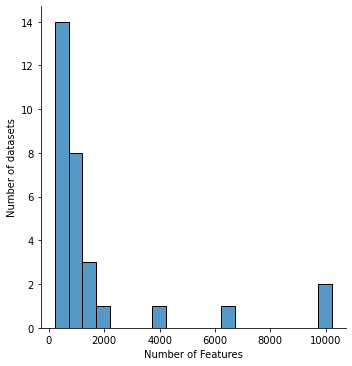

In [3]:
number_of_features = dataset_properties["NumberOfFeatures"].values

ax = sns.displot(number_of_features, binwidth=500)
ax.set(xlabel='Number of Features', ylabel='Number of datasets')
ax.savefig('dataset_feature_distribution.eps')

# 2. Iteration Experiment Evaluation

In [4]:
iter_experiment_path = "../results/iteration_number_experiment/"

In [5]:
def printAllIterationsTestingScore(data):
    # group values for each approach
    gb = data.groupby(["Dataset ID", "Estimator", "Metric", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function"], as_index=False)
    grouped_data = [gb.get_group(x) for x in gb.groups]
    
    for entry in grouped_data:
        index = entry["Iteration Steps"].values
        testing_values = entry["Testing Score"].values
        training_values = entry["Training Score"].values
        title = "-".join(map(str, entry.iloc[0].values[0:7]))
        plt.plot(index, testing_values, label = "Testing")
        plt.plot(index, training_values, label = "Training") 
        plt.xlabel('Number of Iterations') 
        plt.ylabel('Score') 
        plt.title(title)
        plt.legend() 
        plt.show()

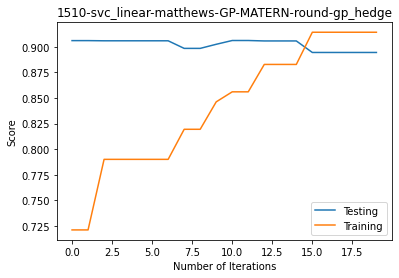

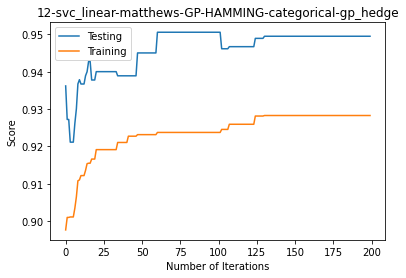

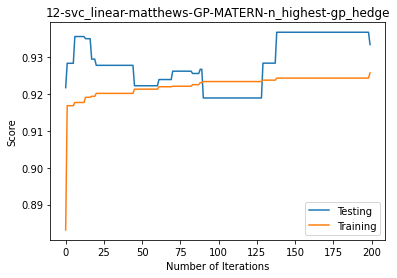

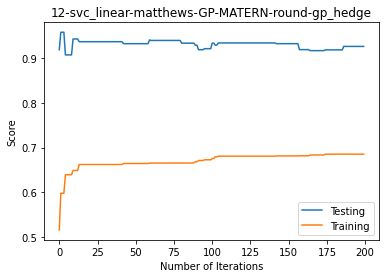

In [6]:
for root, dirs, files in os.walk(iter_experiment_path):
    for filename in files:
        if filename != ".gitignore":
            data = pd.read_csv(iter_experiment_path + filename, skiprows=[1])
            # todo: do something with data
            printAllIterationsTestingScore(data)

# 3. Comparison Experiment

In [7]:
# path where the result csv files are stored
comparison_experiment_path = "../results/comparison_bayesian_experiment/classification/"
comparison_experiment_output_path = "comparison_experiment_plots/"

In [8]:
# Explore available data
dataset_set = set() # set of all dataset id, estimator and metric combinations
filename_list = []

# explore folder and store all dataset ids and filenames
file_list = os.listdir(comparison_experiment_path)
for file in file_list:
    if file.startswith("bayopt") or file.startswith("comparison") or file.startswith("withoutfs"):
        # get properties
        dataset_id = file.split("_")[1]
        estimator = file.split("_")[2] + "_" + file.split("_")[3]
        metric = file.split("_")[4].split(".")[0]
        dataset_set.add((dataset_id, estimator, metric))
        filename_list.append(file)

In [33]:
# Concatinate all bayesian, comparison and withoutfs into one dataframe
all_bayopt_data = pd.DataFrame()
all_comparison_data = pd.DataFrame()
all_withoutfs_data = pd.DataFrame()

for dataset_id, estimator, metric in dataset_set:
    path_suffix = dataset_id + "_" + estimator + "_" + metric + ".csv"
    
    # concat into dataframe
    bayopt_import= pd.read_csv(comparison_experiment_path + "bayopt_" + path_suffix, skiprows=[1])
    bayopt_import["did"] = dataset_id
    bayopt_import["Estimator"] = estimator
    bayopt_import["Metric"] = metric
    bayopt_import["did"] = pd.to_numeric(bayopt_import["did"]) # convert values to int
    all_bayopt_data = pd.concat([all_bayopt_data, bayopt_import])
    all_comparison_data = pd.concat([all_comparison_data,pd.read_csv(comparison_experiment_path + "comparison_" + path_suffix, skiprows=[1])])
    all_withoutfs_data = pd.concat([all_withoutfs_data,pd.read_csv(comparison_experiment_path + "withoutfs_" + path_suffix)])

## 3.1. Score Comparison

In [10]:
def create_bar_plot_of_scores(bayopt_data, comparison_data, withoutfs_data):
    """ Create plot with Bayesian optimization and comparison scores
    
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    bayopt_scores = bayopt_data["Testing Score"].values
    bayopt_labels = [row["Learning Method"] + " - " + row["Kernel"] + " - " + row["Discretization Method"] for index, row in bayopt_data.iterrows()]
    comparison_scores = comparison_data["Testing Score"].values
    comparison_labels = [row["Algorithm"] + " (" + row["Approach"] + ")" for index, row in comparison_data.iterrows()]
    withoutfs_score = withoutfs_data["Testing Score"][0]
    
    ax1.bar(bayopt_labels, bayopt_scores)
    ax1.set_title("BOFS")
    ax1.set_ylim(0,1)
    ax1.axhline(y=withoutfs_score)
    
    ax2.bar(comparison_labels, comparison_scores)
    ax2.set_title("Comparison")
    ax2.set_ylim(0,1)
    ax2.axhline(y=withoutfs_score)
    
    fig.autofmt_xdate()
    
    return fig


In [11]:
def create_correlation_matrix(bayopt_data, comparison_data, withoutfs_data):
    grouped_bayopt_df = bayopt_data.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    grouped_comparison_df = comparison_data.groupby(["Approach", "Algorithm", "n_features"])
    
    data_dict = dict()
    
    for name, group in grouped_bayopt_df:
        label = name[1] + "-" + name[2] + "-" + name[3] + "-" + name[4]
        scores = group["Testing Score"].values
        data_dict[label] = scores
    for name, group in grouped_comparison_df:
        label = name[1] + " (" + name[0] + ")"
        scores = group["Testing Score"].values
        data_dict[label] = scores
    data_dict["Without FS"] = withoutfs_data["Testing Score"].values
    df = pd.DataFrame(data_dict)
    correlation_df = df.corr()
    
    # display only lower diagonal values
    mask = np.zeros_like(correlation_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False
    
    fig, score_heatmap = plt.subplots(figsize=(10,10))
    score_heatmap = sns.heatmap(data=correlation_df, mask=mask, vmin=-1, vmax=1, cmap='RdYlGn', annot=True, square=True, cbar=False)
    
    return score_heatmap
    

In [ ]:
for dataset_id, estimator, metric in dataset_set:
    path_suffix = dataset_id + "_" + estimator + "_" + metric + ".csv"
    
    # create dataframes
    bayopt_data = pd.read_csv(comparison_experiment_path + "bayopt_" + path_suffix, skiprows=[1])
    comparison_data = pd.read_csv(comparison_experiment_path + "comparison_" + path_suffix , skiprows=[1])
    withoutfs_data = pd.read_csv(comparison_experiment_path + "withoutfs_" + path_suffix)
    
    # create plot and save file
    plot = create_bar_plot_of_scores(bayopt_data, comparison_data, withoutfs_data)
    filename = dataset_id + "_" + estimator + "_" + metric + ".eps"
    plot.savefig(comparison_experiment_output_path + "score_comparison/" + filename, format="eps", bbox_inches = "tight")

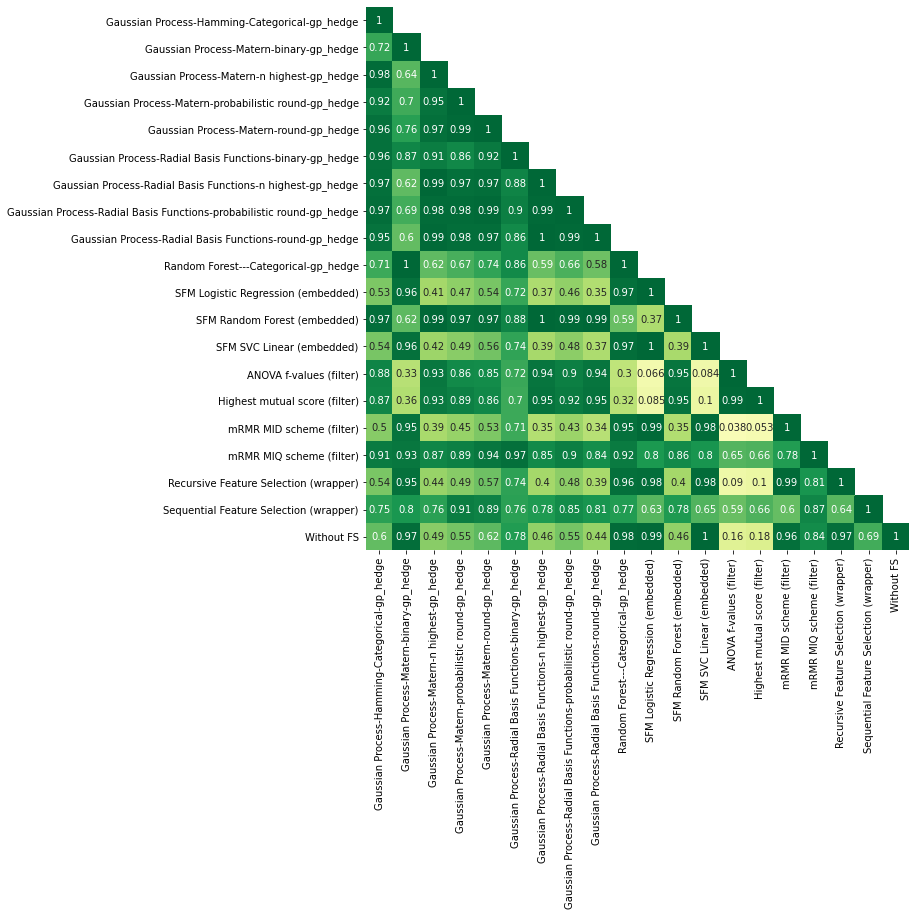

In [13]:
heatmap = create_correlation_matrix(all_bayopt_data, all_comparison_data, all_withoutfs_data)
figure = heatmap.get_figure()
figure.savefig(comparison_experiment_output_path + "score_correlation_heatmap.eps", format="eps", bbox_inches = "tight")

## 3.2. Runtime

### 3.2.1 Overall runtime (BOFS vs Comparison)

In [50]:
def create_box_plot_of_runtime(bayopt_data, comparison_data):
    grouped_bayopt_df = bayopt_data.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    bayopt_durations = []
    bayopt_labels = []
    grouped_comparison_df = comparison_data.groupby(["Approach", "Algorithm", "n_features"])
    comparison_durations = []
    comparison_labels = []
    for name, group in grouped_bayopt_df:
        duration = group["Duration Black Box"] + group["Duration Overhead"]
        bayopt_durations.append(duration.values)
        bayopt_labels.append(name[1] + "-" + name[2] + "-" + name[3] + "-" + name[4])

    for name, group in grouped_comparison_df:
        comparison_durations.append(group["Duration"].values)
        comparison_labels.append(name[1] + " (" + name[0] + ")")

    # Create boxplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.boxplot(bayopt_durations)
    ax1.set_xticklabels(bayopt_labels)
    ax1.set_title("BOFS Overall Runtime")
    ax1.set_ylabel("Runtime [s]") 
    ax2.boxplot(comparison_durations)
    ax2.set_xticklabels(comparison_labels)
    ax2.set_title("Comparison Overall Runtime")
    ax2.set_ylabel("Runtime [s]") 

    # set y axis range to the same for both subplots
    y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
    ax1.set_ylim(0, y_max)
    ax2.set_ylim(0, y_max)

    fig.autofmt_xdate()
    
    return fig
    

In [51]:
def create_box_plot_of_number_of_iterations(bayopt_data):
    return None

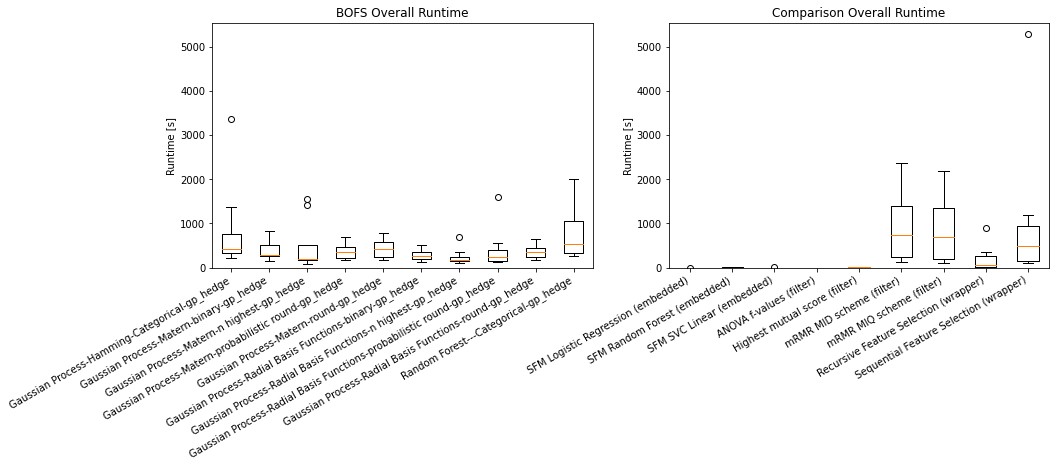

In [52]:
runtime_box_plot = create_box_plot_of_runtime(all_bayopt_data, all_comparison_data)
runtime_box_plot.savefig(comparison_experiment_output_path + "runtime_box_plot.eps", format="eps", bbox_inches = "tight")

iteration_box_plot = create_box_plot_of_number_of_iterations(all_bayopt_data)


#plot = create_box_plot_of_bayopt_runtime(bayopt_data)
#filename = dataset_id + "_" + estimator + "_" + metric + ".eps"
#plot.savefig(comparison_experiment_output_path + filename, format="eps", bbox_inches = "tight")
    
    

## 3.2.2 Dependence of runtime to number of features 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


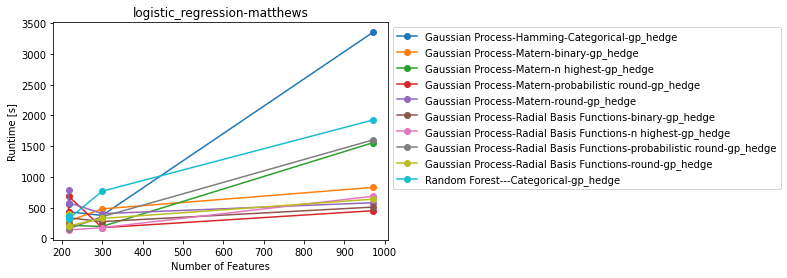

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


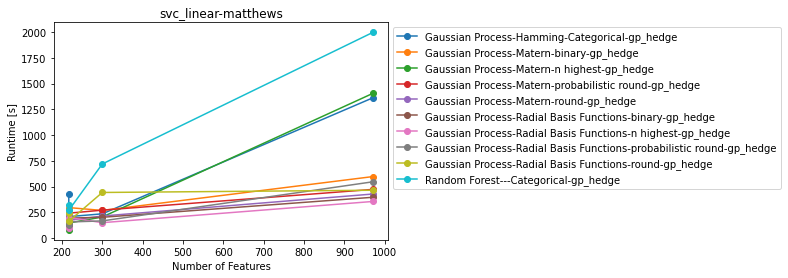

In [55]:
bayopt_data_with_did = pd.merge(all_bayopt_data, dataset_properties, on="did", how="inner") # merge properties about datasets
bayopt_data_with_did_grouped = bayopt_data_with_did.groupby(["Estimator", "Metric"])

for (estimator, metric), group_did in bayopt_data_with_did_grouped:
    bayopt_data_with_estimator_metric_grouped = group_did.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    plt.title(estimator + "-" + metric)
    for name, group in bayopt_data_with_estimator_metric_grouped:
        label = name[1] + "-" + name[2] + "-" + name[3] + "-" + name[4]
        group = group.sort_values(by=["NumberOfFeatures"])
        plt.plot(group["NumberOfFeatures"], group["Duration Black Box"] + group["Duration Overhead"], "-o", label=label)
        plt.xlabel("Number of Features") 
        plt.ylabel("Runtime [s]")
        plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.savefig(comparison_experiment_output_path + "runtime_plots/nr_of_features_dependence_"+estimator+"_"+metric+".eps", format="eps", bbox_inches = "tight")
    plt.show()
    add legend to plot matplotlib



## 3.2.3. BOFS Division of black-box-runtime and overhead runtime

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/patrick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


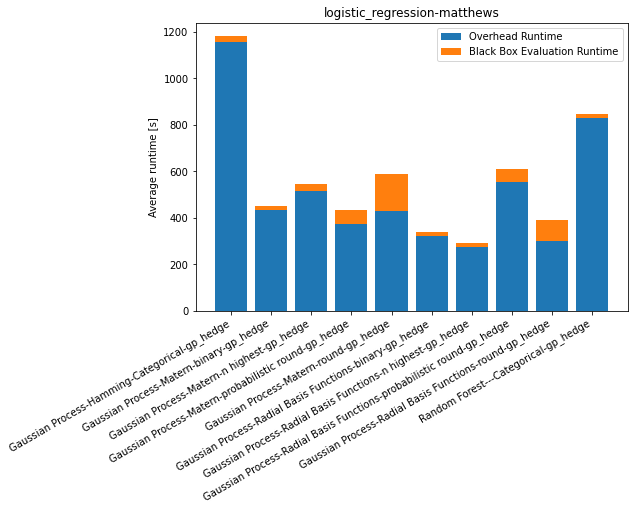

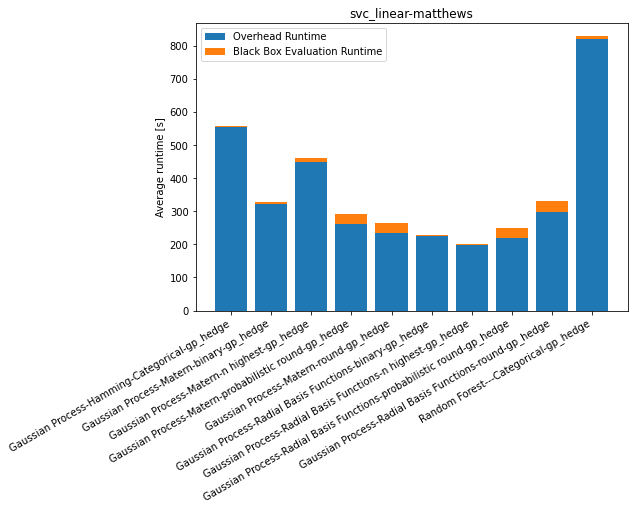

In [83]:
all_bayopt_grouped = all_bayopt_data.groupby(["Estimator", "Metric"])

for (estimator, metric), group_did in all_bayopt_grouped:
    bayopt_data_with_estimator_metric_grouped = group_did.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    values_black_box = []
    values_overhead = []
    labels = []
    for name, group in bayopt_data_with_estimator_metric_grouped:
        values_black_box.append(sum(group["Duration Black Box"])/len(group["Duration Black Box"]))
        values_overhead.append(sum(group["Duration Overhead"])/len(group["Duration Overhead"]))
        labels.append(name[1] + "-" + name[2] + "-" + name[3] + "-" + name[4])

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title(estimator + "-" + metric)
    ax.bar(labels, values_overhead, label="Overhead Runtime")
    ax.bar(labels, values_black_box, bottom=values_overhead, label="Black Box Evaluation Runtime")
    ax.set_ylabel("Average runtime [s]")
    fig.autofmt_xdate()
    ax.legend()
    fig.savefig(comparison_experiment_output_path + "runtime_plots/avg_bayesian_divided_runtime_"+estimator+"_"+metric+".eps", format="eps", bbox_inches = "tight")
    fig.show()
        